# Focused Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the Focused data set. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Focused Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is woth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. The Focused dataset consists on the compilation of all data points that characterize as constraints. Since the objective of this transformation is to study the effect of a more focused dataset on the model performance, after training, the model performance is evaluated on the previous sparse data set. 

In [21]:
import sys; sys.path.append('..')
from thesis_package import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

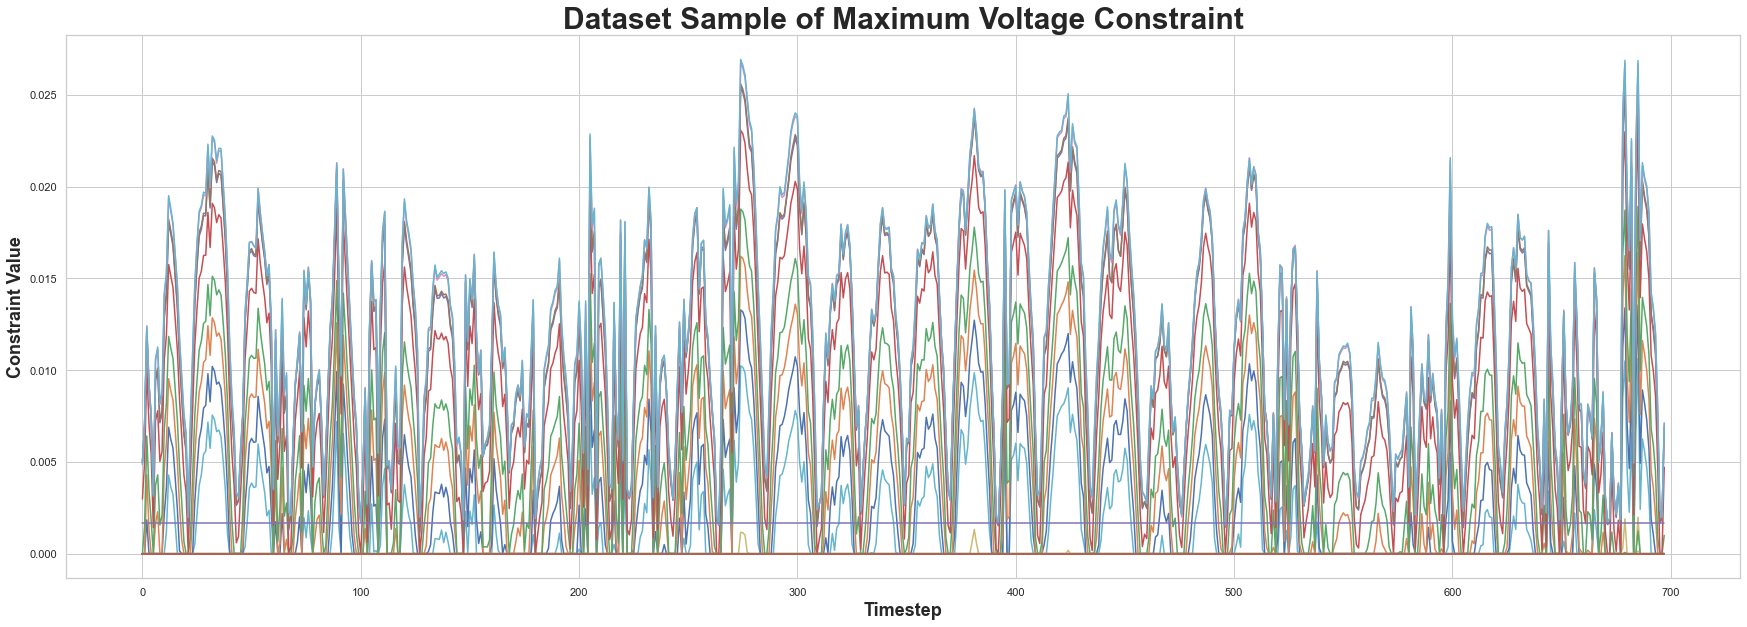

In [22]:
y_max_u_focused = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
exogenous_data_vm_pu_max_focused = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data_vm_pu_max_focused, y_max_u_focused)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

## Import Libraries

In [23]:
import optuna 
import os

import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [24]:
# General parameters
num_trials = 50

### Extreme Gradient Boosting Regressor

In [25]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    return mean_squared_error(valid_y, prediction, squared=False)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-24 23:12:12,800] A new study created in memory with name: no-name-f1c27591-5165-424c-b054-9573526de90e
[I 2022-09-24 23:12:19,133] Trial 0 finished with value: 0.07299242384232045 and parameters: {'booster': 'gblinear', 'lambda': 2.5235316556869046e-06, 'alpha': 0.0012640002565275663, 'subsample': 0.6489605946151424, 'colsample_bytree': 0.24328212980026764}. Best is trial 0 with value: 0.07299242384232045.
[I 2022-09-24 23:15:14,355] Trial 1 finished with value: 0.3375479298148776 and parameters: {'booster': 'dart', 'lambda': 0.045480091779508514, 'alpha': 0.0016630330960102683, 'subsample': 0.4119679878877901, 'colsample_bytree': 0.34827211003707986, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.00787177064236372, 'gamma': 0.0014266811504763997, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0857102442178143, 'skip_drop': 5.311118808960112e-06}. Best is trial 0 with value: 0.07299242384232045.
[I 2022-09-24 23:15:44,627] Tri

Number of finished trials:  50
Best trial:
  Value: 0.07210034785268532
  Params: 
    booster: gblinear
    lambda: 2.9561150396870038e-05
    alpha: 0.0021255751095305736
    subsample: 0.7119400343735331
    colsample_bytree: 0.2865645333043352


In [26]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    return mean_squared_error(valid_y, prediction, squared=False)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 14:18:36,875] A new study created in memory with name: no-name-0ab20d2b-253b-4ed7-8b40-9e00e5318ef6
[I 2022-09-25 14:18:56,447] Trial 0 finished with value: 0.05604302212766667 and parameters: {'booster': 'gblinear', 'lambda': 2.9542620281599622e-05, 'alpha': 0.02396462657199262, 'subsample': 0.638170619966677, 'colsample_bytree': 0.22385926048275862}. Best is trial 0 with value: 0.05604302212766667.
[I 2022-09-25 14:19:10,262] Trial 1 finished with value: 0.04867111308797839 and parameters: {'booster': 'gblinear', 'lambda': 1.3683682047231516e-06, 'alpha': 2.1925610750412252e-08, 'subsample': 0.550454856785233, 'colsample_bytree': 0.20872231292912913}. Best is trial 1 with value: 0.04867111308797839.
[I 2022-09-25 14:19:37,384] Trial 2 finished with value: 0.45288392952791023 and parameters: {'booster': 'gbtree', 'lambda': 1.312709125822607e-08, 'alpha': 0.346662429223109, 'subsample': 0.9654187547747748, 'colsample_bytree': 0.41732565395643306, 'max_depth': 5, 'min_chil

Number of finished trials:  50
Best trial:
  Value: 0.04864510260342804
  Params: 
    booster: gblinear
    lambda: 1.5185872809070974e-07
    alpha: 8.213823895283899e-08
    subsample: 0.38962585233131064
    colsample_bytree: 0.6838595461097349


### Gradient Boosting Regressor

In [27]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    return mean_squared_error(valid_y, prediction, squared=False)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 14:52:46,456] A new study created in memory with name: no-name-5542ef6a-339f-4949-9f10-3414dac84ec9
[I 2022-09-25 14:53:02,613] Trial 0 finished with value: 0.09419953450605167 and parameters: {'n_estimators': 89, 'learning_rate': 0.24983031733390482, 'loss': 'squared_error'}. Best is trial 0 with value: 0.09419953450605167.
[I 2022-09-25 14:53:40,503] Trial 1 finished with value: 0.09567083153451796 and parameters: {'n_estimators': 222, 'learning_rate': 0.14932362900763782, 'loss': 'squared_error'}. Best is trial 0 with value: 0.09419953450605167.
[I 2022-09-25 14:54:12,214] Trial 2 finished with value: 0.09339200775519496 and parameters: {'n_estimators': 131, 'learning_rate': 0.23114606813924116, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.09339200775519496.
[I 2022-09-25 14:54:34,442] Trial 3 finished with value: 0.09452509390204615 and parameters: {'n_estimators': 128, 'learning_rate': 0.21258656493261943, 'loss': 'squared_error'}. Best is trial 2 with va

Number of finished trials:  50
Best trial:
  Value: 0.07828676447892846
  Params: 
    n_estimators: 10
    learning_rate: 0.1277397777263443
    loss: squared_error


In [28]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    return mean_squared_error(valid_y, prediction, squared=False)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 15:06:48,134] A new study created in memory with name: no-name-1e80fbab-1814-4cfb-99ce-aff141e5916c
[I 2022-09-25 15:07:27,634] Trial 0 finished with value: 0.05430022733524879 and parameters: {'n_estimators': 148, 'learning_rate': 0.6606747085606149, 'loss': 'squared_error'}. Best is trial 0 with value: 0.05430022733524879.
[I 2022-09-25 15:08:15,336] Trial 1 finished with value: 0.055668936334561804 and parameters: {'n_estimators': 144, 'learning_rate': 0.9775654065011173, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.05430022733524879.
[I 2022-09-25 15:10:38,954] Trial 2 finished with value: 0.053147163553752465 and parameters: {'n_estimators': 432, 'learning_rate': 0.25128813628178714, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.053147163553752465.
[I 2022-09-25 15:10:48,961] Trial 3 finished with value: 0.05195371116195657 and parameters: {'n_estimators': 37, 'learning_rate': 0.44312174866949905, 'loss': 'squared_error'}. Best is trial 3 with 

Number of finished trials:  50
Best trial:
  Value: 0.049361328169992044
  Params: 
    n_estimators: 23
    learning_rate: 0.16873340986794932
    loss: squared_error


### Support Vector Regressor

In [29]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_max_u.columns)
    valid_y = pd.DataFrame(valid_y, columns=y_max_u.columns)
    return mean_squared_error(valid_y, prediction, squared=False)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 15:26:36,140] A new study created in memory with name: no-name-8a0a223d-3a6a-4048-9483-14d8b0dfc829
[I 2022-09-25 15:26:41,255] Trial 0 finished with value: 0.08617235503221309 and parameters: {'kernel': 'poly', 'C': 1.9485425744021705e-06, 'degree': 3, 'gamma': 1.3294302327870699e-07}. Best is trial 0 with value: 0.08617235503221309.
[I 2022-09-25 15:26:45,985] Trial 1 finished with value: 0.08617235503204217 and parameters: {'kernel': 'poly', 'C': 0.0006078643025068738, 'degree': 3, 'gamma': 0.00011279990354830745}. Best is trial 1 with value: 0.08617235503204217.
[I 2022-09-25 15:26:50,983] Trial 2 finished with value: 0.08617255811374379 and parameters: {'kernel': 'poly', 'C': 1.861483056583515e-07, 'degree': 4, 'gamma': 7.418617286830928e-06}. Best is trial 1 with value: 0.08617235503204217.
[I 2022-09-25 15:26:59,588] Trial 3 finished with value: 0.08617111184929317 and parameters: {'kernel': 'rbf', 'C': 1.8115479183330577e-05, 'degree': 3, 'gamma': 3.74940080935509

Number of finished trials:  50
Best trial:
  Value: 0.08036042675248821
  Params: 
    kernel: poly
    C: 0.05863474807242084
    degree: 3
    gamma: 0.1783152932465746


In [30]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_min_u.columns)
    valid_y = pd.DataFrame(valid_y, columns=y_min_u.columns)
    return mean_squared_error(valid_y, prediction, squared=False)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 15:32:40,745] A new study created in memory with name: no-name-e9021404-6db6-4227-879f-2534d91d50bb
[I 2022-09-25 15:33:05,188] Trial 0 finished with value: 0.058031938715578116 and parameters: {'kernel': 'rbf', 'C': 0.005337822638522267, 'degree': 2, 'gamma': 8.477611852741994e-05}. Best is trial 0 with value: 0.058031938715578116.
[I 2022-09-25 15:33:29,289] Trial 1 finished with value: 0.0580387521854294 and parameters: {'kernel': 'rbf', 'C': 1.2183320860004432e-05, 'degree': 4, 'gamma': 2.1860527941091794e-05}. Best is trial 0 with value: 0.058031938715578116.
[I 2022-09-25 15:33:53,042] Trial 2 finished with value: 0.058044711588773085 and parameters: {'kernel': 'rbf', 'C': 0.005524758116784596, 'degree': 4, 'gamma': 8.78780288626017e-08}. Best is trial 0 with value: 0.058031938715578116.
[I 2022-09-25 15:34:05,830] Trial 3 finished with value: 0.058038812421711834 and parameters: {'kernel': 'poly', 'C': 2.3115427625645143e-07, 'degree': 1, 'gamma': 0.075953133318279

Number of finished trials:  50
Best trial:
  Value: 0.04782616960183752
  Params: 
    kernel: rbf
    C: 0.16377316609499395
    degree: 3
    gamma: 0.9186934763754282
